# Source code

In [119]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from typing import List


class ClipEmbeddingsGenerator:
    """
    Class for generating embeddings for images and texts using CLIP model.
    """

    def __init__(self) -> None:
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(self.device)
        self.processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

    def embedd_images(self, images_paths: List[str]) -> np.array:
        """
        Embedds images using CLIP model.
        :param images_paths: list of paths to images
        :return: embeddings of images
        """
        images = [Image.open(path) for path in images_paths]
        inputs = self.processor(images=images, return_tensors="pt", text=None).to(self.device)
        outputs = self.model.get_image_features(**inputs)
        return outputs.cpu().detach().numpy()
    
    def embedd_texts(self, texts: List[str]) -> np.array:
        """
        Embedds texts using CLIP model.
        :param texts: list of image descriptions
        :return: embeddings of texts
        """
        inputs = self.processor(images=None, return_tensors="pt", text=texts).to(self.device)
        outputs = self.model.get_text_features(**inputs)
        return outputs.detach().cpu().numpy()

def draw_images(images_paths: List[str], titles: List[str] = None) -> None:
    """
    Draws images.
    :param images_paths: list of paths to images
    :param titles: list of titles for images
    """
    images = [mpimg.imread(path) for path in images_paths]

    if len(images_paths) == 1:
        plt.figure(figsize=(10, 5))
        plt.imshow(images[0])
        plt.title(titles[0])
        plt.axis("off")
    else:    
        if titles is None:
            titles = ["" for _ in range(len(images_paths))]
            
        _, axs = plt.subplots(1, len(images), figsize=(10, 5*len(images)))
        for i, (image, title) in enumerate(zip(images, titles)):
            axs[i].imshow(image)
            axs[i].set_title(title)
            axs[i].set_axis_off()
    plt.show()

def to_blob(embedding: np.array) -> bytes:
    """
    Converts embedding to blob.
    :param embedding: embedding
    :return: blob
    """
    return embedding.astype(np.float32).tobytes()

# Generar embeddings de las images

* Primero hay que descargar los retratos del moodle, descomprimir el .zip y subir la carpeta "avatar_portraits" al jupyter lab.
* Luego, al ejecutar este código, las imagenes se cargarán en memoria y se pasaran por el modelo CLIP para generar un emebddings.

**Al ejecutar esta celdilla tendrás un array numpy llamada `embeddings` de tamaño `[229, 512]` (229 images, 512 longitud embedding)**

In [103]:
import numpy as np
import os
from os.path import join

avatar_path = "./avatar_portraits/2024-01-10"
portraists = [join(avatar_path, f) for f in os.listdir(avatar_path) if f.endswith(".png")]

generator = ClipEmbeddingsGenerator()

embeddings = np.zeros((len(portraists), 512), dtype=np.float32)

batch_size = 32
for i in range(0, len(portraists), batch_size):
    images = portraists[i:i+batch_size]
    embeddings[i:i+batch_size] = generator.embedd_images(images)
    

print(f"Done! variable embeddings contains {embeddings.shape[0]} embeddings of size {embeddings.shape[1]}")

Done! variable embeddings contains 229 embeddings of size 512


# Crear conexión a redis

* Hacemos una conexión con la bases de datos redis. La base de datos ya se inició cuando ejecutaste `docker-compose up`. Puedes acceder a *Redis Insights* entrando al puerto 8001.

**Al ejecutar esta celdilla tendrás una conexion con la base de redis lista para usarse**

In [104]:
import redis

r = redis.Redis(host='redis', port=6379)

# Cremos un indice en Redis que nos permite hacer KNN sobre los embeddings de clip

* Usaremos el método `execute_command` para crear el índice en Redis.

**Esta casilla está incompleta, rellena el código para crear el indice en el servidor**

In [105]:
# ESTA CASILLA ESTA SIN COMPLETAR, RELLENA EL CODIGO NECESARIO PARA CREAR UN INDICE FLAT DE TIPO FLOAT32, DIMENSION 512 Y DISTANCIA COSENO
r.execute_command(
"""
FT.CREATE knn 
ON HASH PREFIX 1 imagenes:
SCHEMA img_embedding VECTOR
    FLAT 6
    TYPE FLOAT32 
    DIM 512
    DISTANCE_METRIC COSINE
"""
)

b'OK'

# Subir embeddings de los retratos

* Usaremos el método `hset` para subir los embeddings de los retratos a redis. Tendremos que almacenar el embedding y el nombre de la imagen para poderla cargar

**Esta casilla está parcialmente incompleta, rellena el código del comando `hset` que guarde los vectores en redis**

In [106]:
for i in range(embeddings.shape[0]):
    # RELLENA EL CODIGO NECESARIO QUE EJECUTE EL COMANDO hset
    r.hset(f"imagenes:{i}", mapping={"img_embedding":to_blob(embeddings[i,:]),"img_path": portraists[i]})
    

# Implementar flujos

* Usaremos `Query` para implementar los dos flujos de trabajo. Cada flujo de trabajo devolverá las 5 imágenes más parecidas al vector de búsqueda.

**Esta casilla está parcialmente incompleta, rellena el código del comando `Query` que busque los imagenes más parecidas al vector dado**

## Flujo de texto a imagen

In [ ]:
from redis.commands.search.query import Query

def search_by_text_top_3(text: str, index:str="knn"):
    
    search_embd = generator.embedd_texts([text])[0,:]
    
    query = (
        Query('*=>[KNN 3 @img_embedding $search_embd as score]')  
        .sort_by('score')
        .return_fields("img_path", "score")  # RELLENA CON EL CAMPO QUE CONTIENE EL PATH DE LA IMAGEN
        .dialect(2)
    )
    # RELLENA CON EL NOMBRE DE TU INDICE
    res = r.ft(index).search(
        query,
        {
          'search_embd': to_blob(search_embd) # RELLENA CON EL NOMBRE DEL PARAMETROS DE TU QUERY (empiezan por $)
        }
    ).docs

    print(res)

    # LA VARIABLE res CONTIENE LOS RESULTADOS DE TU QUERY, PROCESA CADA RESULTADO Y GENERA EL PATH DE LA IMAGEN
    similar_images = [elemento['img_path'] for elemento in res]
    
    draw_images(similar_images)

[Document {'id': 'imagenes:53', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00094-113564434.png'}, Document {'id': 'imagenes:204', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}, Document {'id': 'imagenes:220', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00071-1078192847.png'}]


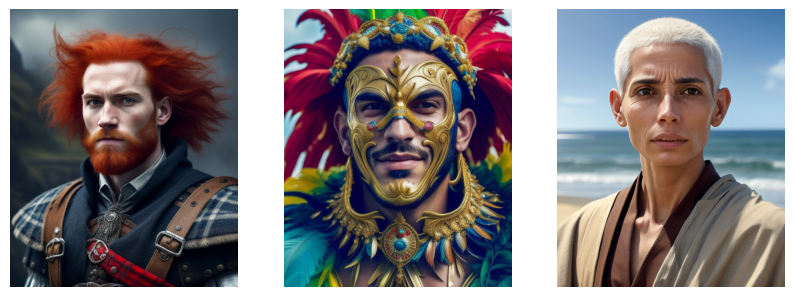

In [121]:
# PRUEBA EL FLUJO CON EL TEXTO QUE QUIERAS
search_by_text_top_3("caballero")

## Flujo de imagen a imagen

In [ ]:
from redis.commands.search.query import Query

def search_by_image_top_3(image_path: str, index:str="knn"):
    
    search_embd = generator.embedd_images([image_path])[0,:]
    
    query = (
        # RELLENA LA QUERY QUE HAY QUE EJECUTAR EN REDIS
        Query('*=>[KNN 3 @img_embedding $search_embd as score]')
             .sort_by('score')
             .return_fields('img_path','score') # RELLENA CON EL CAMPO QUE CONTIENE EL PATH DE LA IMAGEN
             .dialect(2)
    )
    # RELLENA CON EL NOMBRE DE TU INDICE
    res = r.ft(index).search(
        query,
        {
          'search_embd': to_blob(search_embd) # RELLENA CON PARAMETROS DE TU QUERY (empiezan por $)
        }
    ).docs

    print(res)

    # LA VARIABLE res CONTIENE LOS RESULTADOS DE TU QUERY, PROCESA CADA RESULTADO Y GENERA EL PATH DE LA IMAGEN
    similar_images = [elemento['img_path'] for elemento in res]
    
    draw_images(similar_images)

[Document {'id': 'imagenes:55', 'payload': None, 'score': '0.198394596577', 'img_path': './avatar_portraits/2024-01-10/00091-1903728012.png'}, Document {'id': 'imagenes:147', 'payload': None, 'score': '0.289443552494', 'img_path': './avatar_portraits/2024-01-10/00007-651005685.png'}, Document {'id': 'imagenes:180', 'payload': None, 'score': '0.328344166279', 'img_path': './avatar_portraits/2024-01-10/00050-3353873335.png'}]


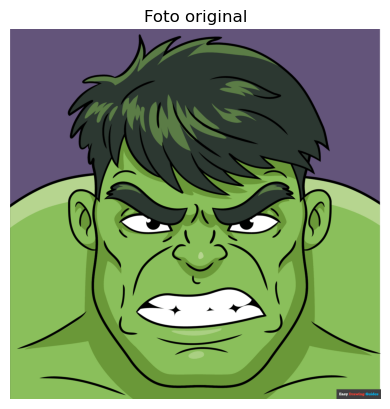

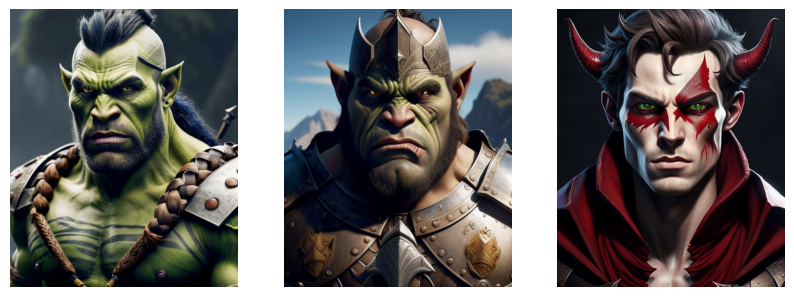

In [124]:
# Sube la imagen que tu quieras al jupyter y coloca aqui su path
image_path = 'hulk.webp'
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Foto original")

search_by_image_top_3(image_path)

[Document {'id': 'imagenes:71', 'payload': None, 'score': '0.429570972919', 'img_path': './avatar_portraits/2024-01-10/00107-4015106057.png'}, Document {'id': 'imagenes:1', 'payload': None, 'score': '0.458765506744', 'img_path': './avatar_portraits/2024-01-10/00151-2438446539.png'}, Document {'id': 'imagenes:204', 'payload': None, 'score': '0.463163614273', 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}]


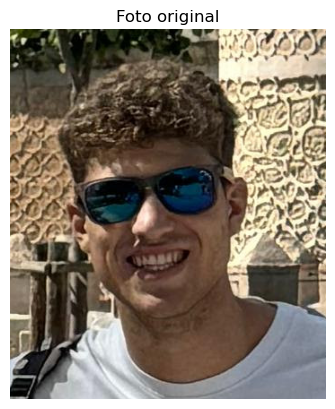

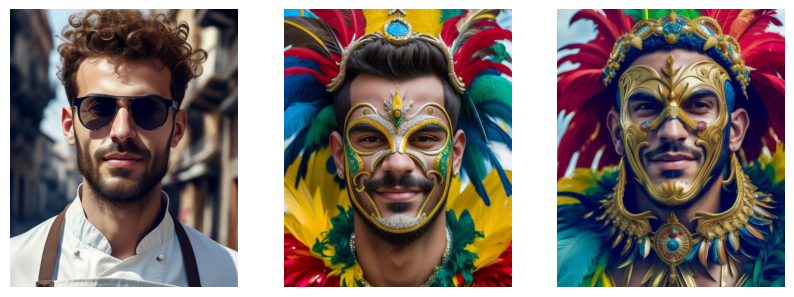

In [125]:
import cv2
image_path = 'cara.png'
plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Foto original")

search_by_image_top_3(image_path)

## Pruebas con distintas métricas y tipos de índice

Probamos a utilizar un tipo de índice HNSW y usando la distancia euclídea 

In [112]:
# CREAMOS euclideo grafo
r.execute_command(
"""
FT.CREATE knn_euclideo_grafo
ON HASH PREFIX 1 imagenes:
SCHEMA img_embedding VECTOR
    HNSW 12
    TYPE FLOAT32 
    DIM 512
    DISTANCE_METRIC L2
    M 30
    EF_CONSTRUCTION 200
    EPSILON 0.02
"""
)

b'OK'

Probamos a utilizar un tipo de índice HNSW y usando la distancia coseno 

In [113]:
# CREAMOS coseno grafo
r.execute_command(
"""
FT.CREATE knn_coseno_grafo
ON HASH PREFIX 1 imagenes:
SCHEMA img_embedding VECTOR
    HNSW 12
    TYPE FLOAT32 
    DIM 512
    DISTANCE_METRIC COSINE
    M 30
    EF_CONSTRUCTION 200
    EPSILON 0.02
"""
)

b'OK'

Probamos a utilizar un tipo de índice flat y usando la distancia euclídea 

In [114]:
# CREAMOS euclideo flat
r.execute_command(
"""

FT.CREATE knn_euclideo
ON HASH PREFIX 1 imagenes:
SCHEMA img_embedding VECTOR
    FLAT 6
    TYPE FLOAT32 
    DIM 512
    DISTANCE_METRIC L2
"""
)

b'OK'


=== Búsqueda en índice: knn_euclideo_grafo === 

[Document {'id': 'imagenes:173', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00073-187914782.png'}, Document {'id': 'imagenes:23', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00057-2214081253.png'}, Document {'id': 'imagenes:24', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00033-2284453211.png'}]


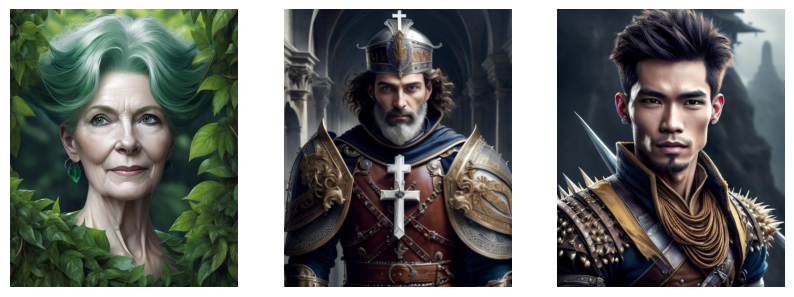


=== Búsqueda en índice: knn_coseno_grafo === 

[Document {'id': 'imagenes:26', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00070-2069208578.png'}, Document {'id': 'imagenes:53', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00094-113564434.png'}, Document {'id': 'imagenes:68', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00103-2980149668.png'}]


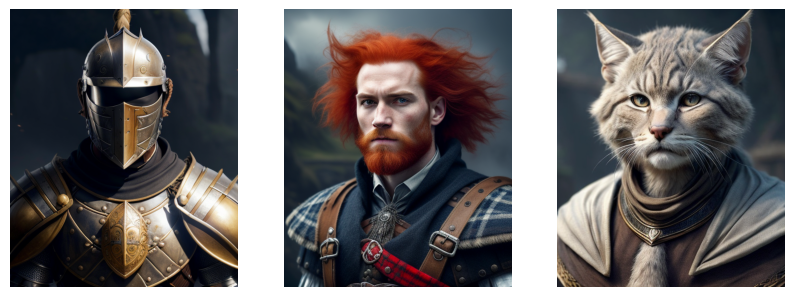


=== Búsqueda en índice: knn_euclideo === 

[Document {'id': 'imagenes:173', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00073-187914782.png'}, Document {'id': 'imagenes:23', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00057-2214081253.png'}, Document {'id': 'imagenes:24', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00033-2284453211.png'}]


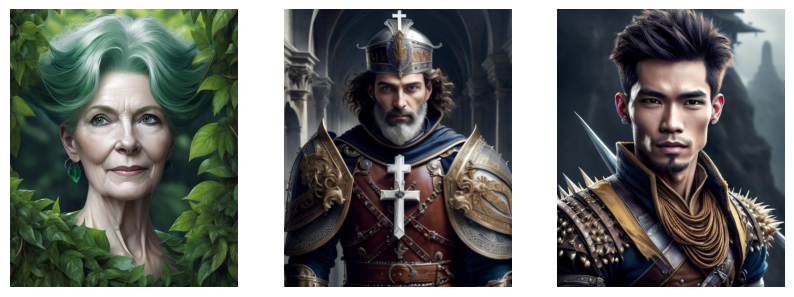


=== Búsqueda en índice: knn === 

[Document {'id': 'imagenes:53', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00094-113564434.png'}, Document {'id': 'imagenes:204', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}, Document {'id': 'imagenes:220', 'payload': None, 'img_path': './avatar_portraits/2024-01-10/00071-1078192847.png'}]


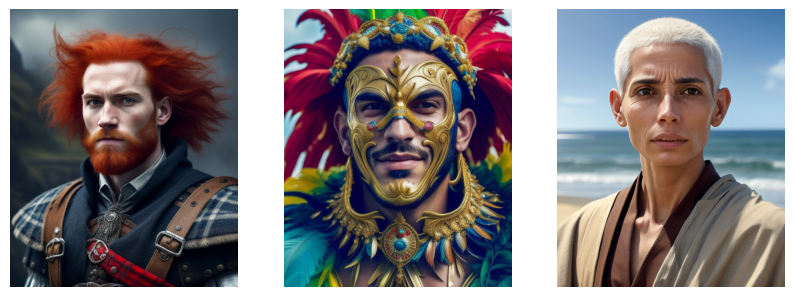

In [135]:
# prueba de texto
prompt="caballero"

indices = [
    "knn_euclideo_grafo",
    "knn_coseno_grafo",
    "knn_euclideo",
    "knn"
]

for indice in indices:
    print(f"\n=== Búsqueda en índice: {indice} === \n")
    search_by_text_top_3(prompt, indice)



Vemos que con prompt de textos si que hay distinciones. Consideramos que el índice que mejor funciona es el índice usando un grafo con la métrica coseno


=== Búsqueda en índice: knn_euclideo_grafo === 

[Document {'id': 'imagenes:71', 'payload': None, 'score': '106.468505859', 'img_path': './avatar_portraits/2024-01-10/00107-4015106057.png'}, Document {'id': 'imagenes:1', 'payload': None, 'score': '107.740478516', 'img_path': './avatar_portraits/2024-01-10/00151-2438446539.png'}, Document {'id': 'imagenes:204', 'payload': None, 'score': '110.579162598', 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}]


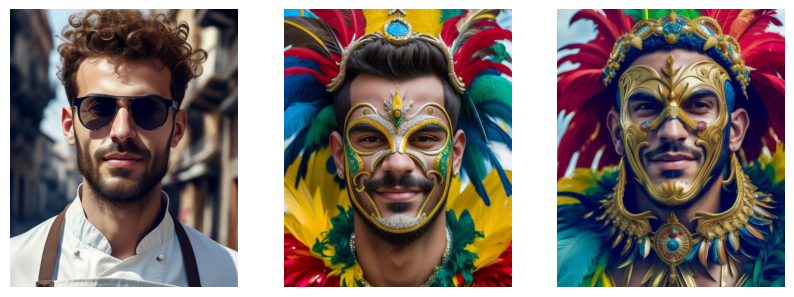


=== Búsqueda en índice: knn_coseno_grafo === 

[Document {'id': 'imagenes:71', 'payload': None, 'score': '0.429570972919', 'img_path': './avatar_portraits/2024-01-10/00107-4015106057.png'}, Document {'id': 'imagenes:1', 'payload': None, 'score': '0.458765506744', 'img_path': './avatar_portraits/2024-01-10/00151-2438446539.png'}, Document {'id': 'imagenes:204', 'payload': None, 'score': '0.463163614273', 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}]


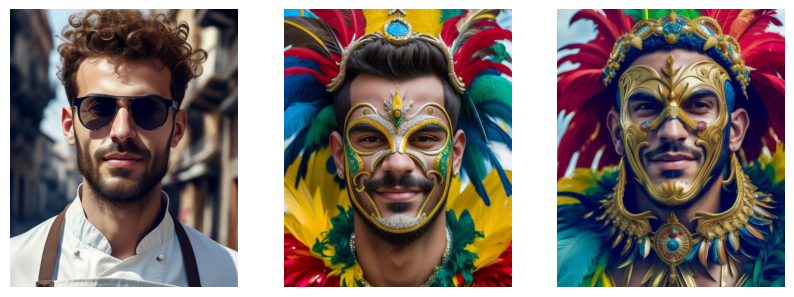


=== Búsqueda en índice: knn_euclideo === 

[Document {'id': 'imagenes:71', 'payload': None, 'score': '106.468505859', 'img_path': './avatar_portraits/2024-01-10/00107-4015106057.png'}, Document {'id': 'imagenes:1', 'payload': None, 'score': '107.740478516', 'img_path': './avatar_portraits/2024-01-10/00151-2438446539.png'}, Document {'id': 'imagenes:204', 'payload': None, 'score': '110.579162598', 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}]


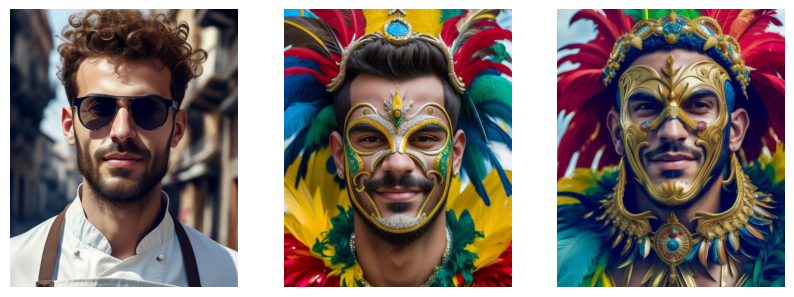


=== Búsqueda en índice: knn === 

[Document {'id': 'imagenes:71', 'payload': None, 'score': '0.429570972919', 'img_path': './avatar_portraits/2024-01-10/00107-4015106057.png'}, Document {'id': 'imagenes:1', 'payload': None, 'score': '0.458765506744', 'img_path': './avatar_portraits/2024-01-10/00151-2438446539.png'}, Document {'id': 'imagenes:204', 'payload': None, 'score': '0.463163614273', 'img_path': './avatar_portraits/2024-01-10/00152-680883839.png'}]


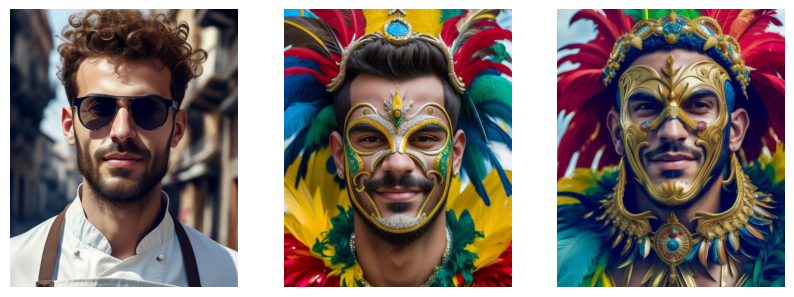

In [138]:
#prueba de imagen
path="cara.png"

indices = [
    "knn_euclideo_grafo",
    "knn_coseno_grafo",
    "knn_euclideo",
    "knn"
]

for indice in indices:
    print(f"\n=== Búsqueda en índice: {indice} === \n")
    search_by_image_top_3(path, indice)



En imagenes funcionan todos igual, tanto con la cara como con la imagen de Hulk